<a href="https://colab.research.google.com/github/RJN25/UTSxCUCAI-DEEPL-Team2-PredictiveMaintenance/blob/main/UTSxCUCAI_Jet_Engine_Predictive_Maintenace_%26_Damage_Propogation_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predictive Maintenance for Nasa Jet Engines


In [180]:
from google.colab import drive
drive.mount('/content/drive') ## sync this collab with the project google drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
!pip install pandas
!pip install numpy
!pip install tensorflow

import pandas as pd
import tensorflow as tf
import numpy as np

In [182]:
dframefd1_train = pd.read_csv("/content/drive/My Drive/UTSxCUCAI - Jet Engine Predictive Maintenance Using Deep Learning/engine_data/train_FD001.txt", sep=" ", header=None, engine="python")

In [183]:
dframefd1_test = pd.read_csv("/content/drive/My Drive/UTSxCUCAI - Jet Engine Predictive Maintenance Using Deep Learning/engine_data/test_FD001.txt", sep=" ", header=None, engine="python")

In [184]:
dframefd1_train.describe() ##  By default, .describe() provides the count, mean, standard deviation, minimum, 25th percentile (Q1),
                            ##median (50th percentile or Q2), 75th percentile (Q3), and maximum of the columns for the data as a quick preview

# Important notes here are the 20631 rows of data entries for the respective 26 columns

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


**Engine Schematic & Sensor Anatomy**

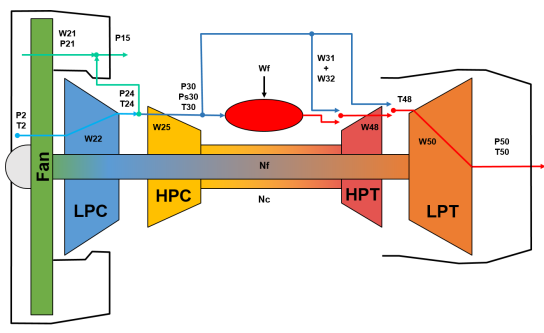

In [185]:
dframefd1_train.drop(columns=[26,27], inplace=True) # dropping unnecessary columns


In [186]:
dframefd1_test.drop(columns=[26,27], inplace=True) # drop unnecessary stuff in test_data

In [187]:
## Define data colums for the jet engine dataframe - mapping the sensors
jet_engine_datacols = ["unit", "cycle_number", "operational_setting_1", "operational_setting_2", "TRA",
                        "T2", "T24", "T30", "T50", "P2", "P15", "P30",
                        "Nf", "Nc", "epr", "Ps30", "phi", "NRf", "NRc",
                        "BPR", "farB", "htBleed", "Nf_dmd", "PCNfR_dmd", "W31", "W32"]

### Understanding the sensors, their mapping, measurements, and units
# 26 input features

# Important notes; SEE THE ATTACHED TURBOFAN ENGINE SCHEMATIC To cross-reference sensors to their design components

## Some Important Metric Data:

  # Rankine Scale - measured in °R - measures the absolute temperature relative to Fahrenheit (similar to how Kelvin measures the absolute temp relative to Celsius)
  # Rankine Temperature Formula: Tr = Tf + 459.67°

  # psia - pounds per square inch absolute - meaning that its measured relative to a perfect vacuum, not the SATP conditions of our atmosphere
  # pps - pounds per second, measures fuel flow in aircraft rather than volume-based metrics, as densities differ
  # lbm/s - pounds mass per second, same as pps, considering mass of fluid
  # Bleed Enthalpy - energy stored in the bleeding air of the system, air taken from the compressor before fuel-burning sections - dependent on specific heat capacity of ambient air composition
  # rpm - revolutions per minute
  # MACH Number - the ratio of the speed of a body to the speed of sound in the surrounding medium, used with a numeral as an integer multiple of the speed of sound (343 m/s)
  # TRA - throttle resolver angle, depicts percentage of power that the engine is operating at, relative to its capacity

## INPUT FEATURES + SENSOR MAPPINGS (For Dataframe Columns):
# See Turbofan Engine Schematic for Sensor Anatomy (below)

# 1) unit - unit number, which machine is being measured
# 2) cycle_number - time in cycles of the test/trial run
# 3) operational_setting_1 - altitude in thousands of feet, ranging from 0-42k
# 4) operational_setting_2 - MACH number from 0 - 0.84 (mostly subsonic fan speeds - recording speeds / partial Transonic speeds)
# 5) /Operational Setting 3 - TRA - throttle resolver angle from, ranging from 20-100
# 6) Sensor 1 - T2 - total temperature at the Fan Inlet, measured in Rankine
# 7) Sensor 2 - T24 - total temperature at LPC outlet (low pressure compressor), measured in Rankine
# 8) Sensor 3 - T30 - total temperature at HPC outlet (high pressure compressor), measured in Rankine
# 9) Sensor 4 - T50 - total temperature at LPC outlet (low pressure compressor) #2, measured in Rankine
# 10) Sensor 5 - P2 - pressure at Fan Inlet, psia
# 11) Sensor 6 - P15 - total pressure in bypass-duct, psia
# 12) Sensor 7 - P30 - total pressure at HPC outlet, psia
# 13) Sensor 8 - Nf - physical fan speed, rpm
# 14) Sensor 9 - Nc - physical core speed, rpm
# 15) Sensor 10 -epr - engine pressure ratio (P50/P2), unitless - P50 isn't a trained sensor, yet measures LPT (Low Pressure Turbine) Pressure, psia
# 16) Sensor 11 - Ps30 - static pressure at HPC outlet, psia
# 17) Sensor 12 - phi - ratio of fuel flow to Ps30, pps/psi
# 18) Sensor 13 - NRf - corrected fan speed, rpm
# 19) Sensor 14 - NRc - corrected core speed, rpm
# 20) Sensor 15 - BPR - bypass ratio, unitless
# 21) Sensor 16 - farB - burner fuel-air ratio, unitless
# 22) Sensor 17 - htBleed - Bleed Enthalpy, unitless
# 23) Sensor 18 - Nf_dmd - demanded fan speed, rpm
# 24) Sensor 19 - PCNfR_dmd - demanded corrected fan speed, rpm
# 25) Sensor 20 - W31 - HPT (high-pressure turbine) coolant bleed, lbm/s
# 26) Sensor 21 - W32 - LPT (low-pressure turbine) coolant bleed, lbm/s


# Total 26 Input Features



In [188]:
dframefd1_train.columns = jet_engine_datacols # labelling the dataframe columns to the mapped input feature names

## assigning the dataframe columns to the named and mapped datacol features

In [189]:
dframefd1_test.columns = jet_engine_datacols ## assign the test_data to the same columns

In [190]:
dframefd1_train.describe() # check to see if the data was labelled properly

,unit,cycle_number,operational_setting_1,operational_setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [191]:
dframefd1_train.drop(columns=['Nf_dmd', 'PCNfR_dmd', 'P2', 'T2', 'TRA', 'farB', 'epr'], inplace=True)
# removing constant values, such as ratios, or constant values that do not provide value to the variabled-state of the engine
# we can remove them, and use the leftover important data input features which indicate engine health significantly, to proceed with the model

**Heat-Mapping Differences & Variable Changes in Input Data & Modelling Errors**

In [192]:
## RUL Is the one-dimensional output feautre that we want to predict - Remeaining Useful Lifetime of the Machine (Engine) operating at a certain TRA (throttle resolver angle)

## Now a RUL VALUE needs to be assigned to each row (cycle) in dframefd1_train by subtracting the engine’s current cycle from its max cycle
## By subtracting the max cycle from the current cycle, we can get the remaining useful lifetime of the engine, it yields the number of cycles left before failure - provided the RUL_FD001 vector data

# Function for defining RUL as a difference from TOTAL REMAINING CYCLES - CURRENT CYCLE (which intuitively yields the remaining amount of cycles - the RUL vector)

def structure_train_data(data, filter_factor = 0): # we set filter_factor = 0 to ensure we can filter out early cycles with too-early data
  dframe = data.copy() # copy the inputted data list
  dframe_RUL = dframe.groupby('unit')['cycle_number'].max().reset_index() # retrieve the max value, and reset the dframes index to update value
  dframe_RUL = pd.DataFrame(dframe_RUL)
  dframe_RUL.columns = ['unit', 'max']
  dframe = dframe.merge(dframe_RUL, on=['unit'], how='left')
  dframe['RUL'] = dframe['max'] - dframe['cycle_number'] # ensure these are integers
  dframe.drop(columns=['max'], inplace = True) # drop max column as we already calculated RUL

  return dframe[dframe['cycle_number'] > filter_factor] # ensure we are getting quality entries that arent from time-series data which was started too early



In [193]:
dframe = structure_train_data(dframefd1_train) # this dframe is different than the one established in structure_train_data()

In [194]:
dframe=dframe.dropna(axis=1, how="all") # drop null rows

In [195]:
## Briefly testing if the training data preprocessed and structured, correctly and fully
try:
    n_display = int(input("Enter # Rows To Display: "))
    test_display = dframe.head(n_display) # .head() will display the inputted amount of rows, or assumes 5 rows as default

    max_row = dframe.shape ## .shape (also since its an attribute and not a function there is no .() ) will return a tuple of the dimensions of the dataframe, so I can compare the inputted row quantity to the total number of rows in the dataset, and see if the quantity of rows are exceeded
                              # The first element of the tuple is the number of rows, and the second element is the number of columns

    if n_display > max_row[0]:
        print("The number of rows you entered is greater than the total number of rows in the dataset.")
    else:
        print(test_display)
except ValueError:
    print("Row quantities exist only as integers.") #

Enter # Rows To Display: 30
    unit  cycle_number  operational_setting_1  operational_setting_2     T24  \
0      1             1                -0.0007                -0.0004  641.82   
1      1             2                 0.0019                -0.0003  642.15   
2      1             3                -0.0043                 0.0003  642.35   
3      1             4                 0.0007                 0.0000  642.35   
4      1             5                -0.0019                -0.0002  642.37   
5      1             6                -0.0043                -0.0001  642.10   
6      1             7                 0.0010                 0.0001  642.48   
7      1             8                -0.0034                 0.0003  642.56   
8      1             9                 0.0008                 0.0001  642.12   
9      1            10                -0.0033                 0.0001  641.71   
10     1            11                 0.0018                -0.0003  642.28   
11     1    

In [196]:
## Using seaborn to produce a heatmap of sign changes, and value weightage (relative to normalcy) of engine performance

# install seaborn

!pip install seaborn
!pip install matplotlib

import seaborn as sbn
import matplotlib.pyplot as plt


In [197]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit")
    max_cycle = grouped_by_unit["cycle_number"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle_number"]
    result_frame["RUL"] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame



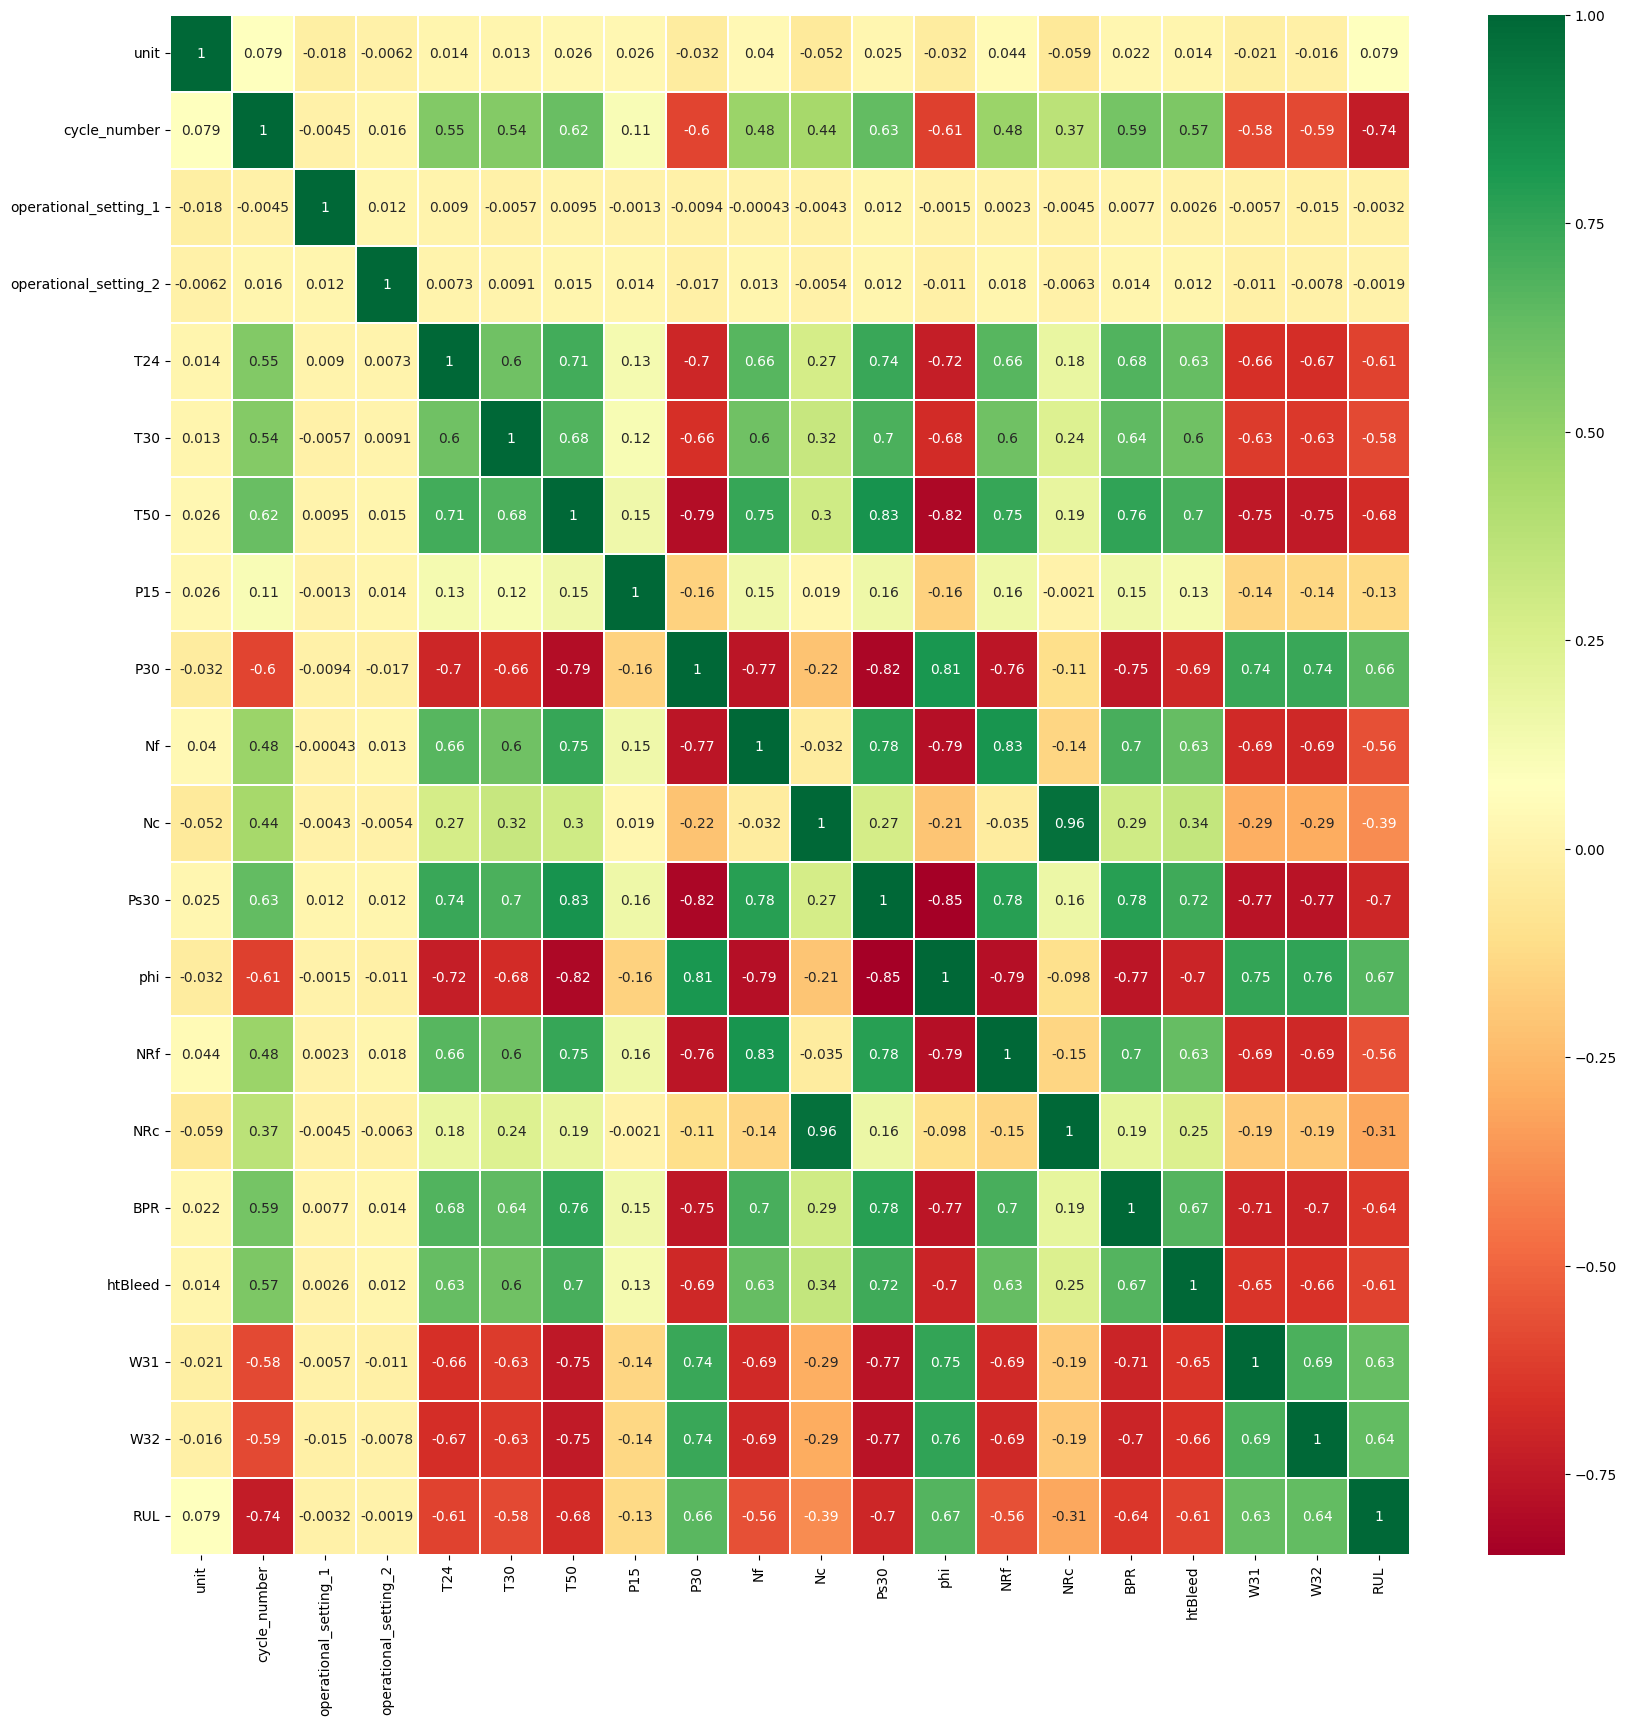

In [198]:
## Define and setup heatmap
dframe = add_remaining_useful_life(dframe) # Add RUL for unit to the table
sbn.heatmap(dframe.corr(), annot = True, cmap='RdYlGn', linewidths=0.3) # .corr will draw pairwise correlations from the data and then create a color-encoded matrix to visualize

heatmap = plt.gcf() # get current figure
heatmap.set_size_inches(20, 20)
plt.show() # display

Above is a heatmap showing the corrolations between each of the sensors and the RUL (remaining useful lifetime) of each unit.

**Error Functions (RMSE & MAE)**

In [199]:
import math

In [200]:
# we will use these error functions later to determine accuracy

# penalization error system, exponentially punishes overestimation over underestimation

def error_score(rul_true, rul_pred, a1=10, a2=13): #a1 is a penalty for underestimation, a2 is a penalty for overestimation for RUL
                                                   # if a model underestimates, it leads to unnecessary call for maintenance and increased cost
                                                   # meanwhile if a model overestimates, it predicts the engine will last longer than it actually will
                                                   # a2 is > a1 because overestimation should be punished harder - as complete engine failure is a opportunity cost rather than spending more money
    score = 0                                      # arbitrarily otpimized penalty points

    d = rul_pred - rul_true # rul_pred is our predicted RUL value, where rul_true, is the actual rul value
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1
        else:
            score += math.exp(- i/a1) - 1
    return score

    # provides an error score now




In [201]:
!pip install -U scikit-learn # install sklearn

In [202]:
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [203]:
# using the error scores we can print different error types now

def print_scores(rul_true, rul_pred):
  error_list = [round(error_score(rul_true,rul_pred), 2), #
                round(mean_absolute_error(rul_true,rul_pred), 2), # MAE
                round(mean_squared_error(rul_true,rul_pred), 2)**0.5, # MSE
                round(r2_score(rul_true,rul_pred), 2)] # r2 regression error score


  print(f' Overall competitive estimation score: {error_list[0]}')
  print(f' Mean absolute error: {error_list[1]}')
  print(f' Root mean squared error: {error_list[2]}')
  print(f' R2 score: {error_list[3]}')

  return [error_list[1], round(error_list[2], 2), (error_list[3])*100]

**Restructuring Dataframe Properties & Implementing LSTM (Long short-term memory) RNN**

In [204]:
unit_number = pd.DataFrame(dframe['unit'])
train_dframe = dframe.drop(columns = ['unit','operational_setting_1','operational_setting_2','P15','NRc']) ## updated training dataframe

# these features weakly correlate to the RUl targe t vector, therefore we can just drop them


**Final Preprocessed Dataframe**

In [205]:
train_dframe.head(20)

,cycle_number,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
5,6,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,2388.03,8.4108,391,38.98,23.3669,186
6,7,642.48,1592.32,1397.77,554.34,2388.02,9059.13,47.36,522.32,2388.03,8.3974,392,39.10,23.3774,185
7,8,642.56,1582.96,1400.97,553.85,2388.00,9040.80,47.24,522.47,2388.03,8.4076,391,38.97,23.3106,184
8,9,642.12,1590.98,1394.80,553.69,2388.05,9046.46,47.29,521.79,2388.05,8.3728,392,39.05,23.4066,183
9,10,641.71,1591.24,1400.46,553.59,2388.05,9051.70,47.03,521.79,2388.06,8.4286,393,38.95,23.4694,182


**Sample Data Visualizations For Sensor Data (Over Cycle Time)**

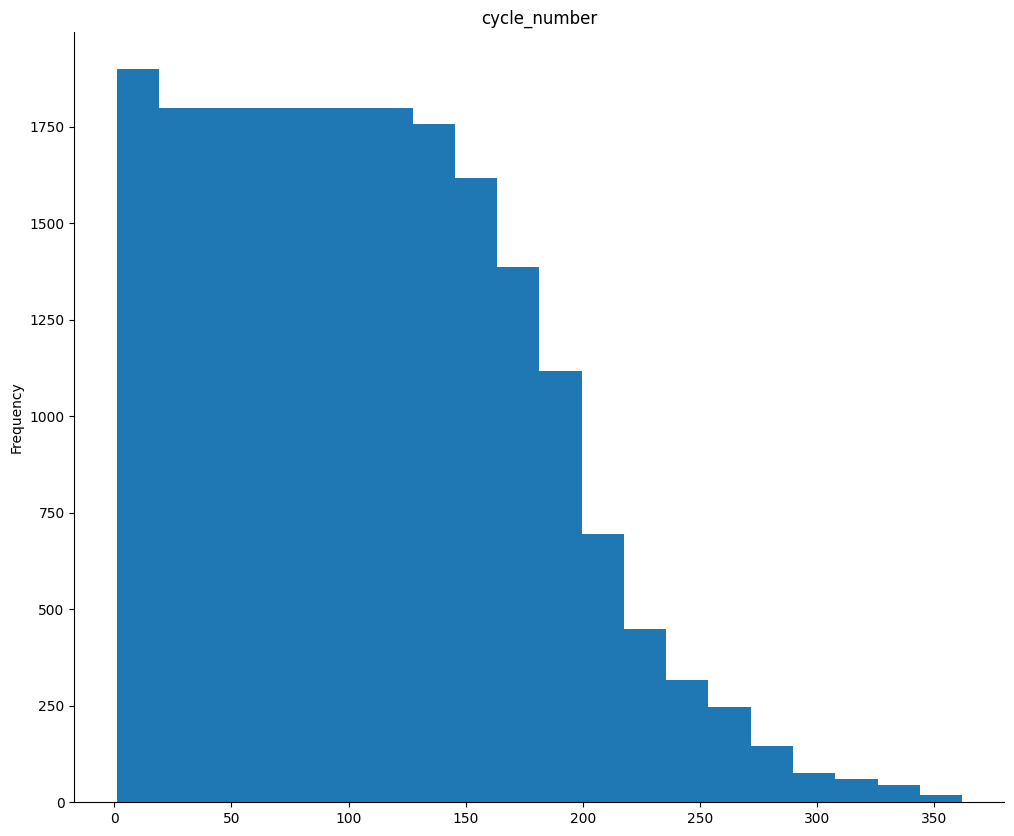

In [206]:
# @title cycle_number

from matplotlib import pyplot as plt
train_dframe['cycle_number'].plot(kind='hist', bins=20, title='cycle_number')
plt.gca().spines[['top', 'right',]].set_visible(False)

**Preprocessing Data For The LSTM**

In [207]:
import numpy

In [208]:
from sklearn.preprocessing import MinMaxScaler

In [209]:
## preprocess

def lstm_preprocessing(raw_train_data, raw_test_data, raw_RUL_data):
  train_dframe = raw_train_data.copy()

  # test_dframe = raw_test_data.copy()  ## ADDED test data and .copy() for dframe assurance

  true_dframe = raw_RUL_data.copy() # the true and ACTUAL RUL values, not what we are predicting

  normalize_cols = train_dframe.columns.difference(['unit','cycle_number','RUL','label1','label2']) # diff between two sets

  # producing a simple binary classification, if a RUL exceeds a threshold, then failure is imminent and engine fails, if not, vice versa
  # a second threshold will act as the buffer zone
  # Add debugging prints to check column types
  print("Checking difference attribute inside lstm_preprocessing...")
  print("train_dframe type:", type(train_dframe))  # Check the type of train_dframe
  print("train_dframe columns:", train_dframe.columns)  # Print column names
  print("normalize_cols:", normalize_cols)  # Print the columns to be used for normalization
  print("normalize_cols type:", type(normalize_cols))  # Check type of normalize_cols

  try:
      print("train_dframe columns difference test:", train_dframe.columns.difference(normalize_cols))
  except Exception as e:
      print("Error using .difference() on train_dframe.columns:", e)

  ## TRAIN PREPROCESS

  w1 = 30
  w0 = 10 # creates a soft label

  train_dframe['label1'] = np.where(train_dframe['RUL'] <= w1, 1, 0 ) # .where - find index of a condition in the array
  train_dframe['label2'] = train_dframe['label1']
  train_dframe.loc[train_dframe['RUL'] <= w0, 'label2'] = 2 # .loc accesses a specific column or row by feature label

  # minmax normalizeation - good for binary, minimize loss of maximum loss scenario, helps gradient descent converge faster and overall all NNs work faster on scaled data

  train_dframe['cycle_norm'] = train_dframe['cycle_number'] # normalize the current cycle


  min_max_scaler = MinMaxScaler()

  transformed_fit = min_max_scaler.fit_transform(train_dframe[normalize_cols])
  normalized_train_dframe = pd.DataFrame(transformed_fit,
                                         columns = normalize_cols,
                                         index = train_dframe.index) # index elps with aseries of labels for each row

  aggregate_dframe = train_dframe[list(set(train_dframe.columns) - set(normalize_cols))].join(normalized_train_dframe) # calculate the set difference


  train_dframe = aggregate_dframe.reindex(columns = train_dframe.columns) # the new aggregated training dataframe is now scaled and normalized

  print("Training Dataframe: ", train_dframe.head(20), "/n")

  ## TEST PREPROCESS

  test_dframe = raw_test_data.drop(columns = ['operational_setting_1','operational_setting_2','P15','NRc','max'])

  # MinMax normalization once again
  test_dframe['cycle_norm'] = test_dframe['cycle_number']
  normalized_test_dframe = pd.DataFrame(min_max_scaler.transform(test_dframe[normalize_cols]),
                              columns = normalize_cols,
                              index=test_dframe.index)

  test_aggregate_dframe = test_dframe[test_dframe.columns.difference(normalize_cols)].join(normalized_test_dframe)

  test_dframe = test_aggregate_dframe.reindex(columns = test_dframe.columns)

  test_dframe = test_dframe.reset_index(drop = True) # so the index resets

  ## now going to use the true data to generate labels for the test data

  rul = pd.DataFrame(test_dframe.groupby('unit')['cycle_number'].max()).reset_index()
  rul.columns = ['unit','max']
  true_dframe.columns = ['more']
  true_dframe['unit'] = true_dframe.index + 1
  true_dframe['max'] = rul['max'] + true_dframe['more'] # adding true-rul vlaue + max cycle of test data actually points out the moment of failure
  true_dframe.drop('more', axis=1, inplace=True)

  test_dframe = test_dframe.merge(true_dframe, on=['unit'], how='left') ## merge the actual RUL data with the test data
  test_dframe['RUL'] = test_dframe['max'] - test_dframe['cycle_number']
  test_dframe.drop('max', axis=1, inplace=True)

  # will now make label columns w0 and w1 for test data, setting the 2 thresholds for a failure
  test_dframe['label1'] = np.where(test_dframe['RUL'] <= w1, 1, 0 ) # find the index of condition
  test_dframe['label2'] = test_dframe['label1']
  test_dframe.loc[test_dframe['RUL'] <= w0, 'label2'] = 2


  print("Test Dataframe: ", test_dframe.head(30)) ## fully preprocessed test dataframe

  ## select a sequence cycle length large enough to capture lifetime data

  cycle_sequence = 50 # rougly 80-100 cycles in lifetime for a unit

  ## now need a function to reshape the feature vectors into samples, time steps, and their respective features

  def generate_sequence(id_dframe, sequence_length, sequence_columns):

    matrix_data = id_dframe[sequence_columns].values ## add the id dframes columnar values
    elenums = matrix_data.shape[0] # number of elements in matrix

    ## zip over elements, looping over MULTIPLE lsits faster, iterates through LSTM
    # credit to: https://realpython.com/python-zip-function/

    for start, stop in zip(range(0, elenums-sequence_length), range(sequence_length, elenums)):
            yield matrix_data[start:stop, :] # keep generating sequences

    # end func

  sequence_cols = list(test_dframe.columns[:-3]) # reverse over last 3 columns

  print(sequence_cols) # display the new sequence columns

  ## value_list is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)

  value_list = list(generate_sequence(train_dframe[train_dframe['unit']==1], cycle_sequence, sequence_cols))
  print(len(value_list)) # understand the quantity of contents for the value list bidimensional array

  # generate the sequences now

  sequence_gen = (list(generate_sequence(train_dframe[train_dframe['unit']==id], cycle_sequence, sequence_cols))
               for id in train_dframe['unit'].unique()) # non repeating values - completely unique and new generated sequences

  array_sequence = np.concatenate(list(sequence_gen)).astype(np.float32)

  print(array_sequence.shape) # returns dimensions of the sequence generated array

  ## now labels must be generated to match the sequences

  def generate_labels(id_dframe, sequence_length, label):
    label_matrix_data = id_dframe[label].values
    label_elenums = label_matrix_data.shape[0]

    return label_matrix_data[sequence_length:label_elenums, :]
    ## end func

  label_gen = [generate_labels(train_dframe[train_dframe['unit']==id], cycle_sequence, ['RUL'])
                 for id in train_dframe['unit'].unique()] # once again return unique labels


  label_array = np.concatenate(label_gen).astype(np.float32)
  print(label_array.shape) # return dimensions of the label generated array
  print(label_array)

  return array_sequence, label_array, test_dframe, cycle_sequence, sequence_cols

  #end func








**Integrating Preprocessed Data Into The LSTM Model**

In [210]:
## Keras for RNN

!pip install Keras
!pip install tensorflow --upgrade

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential, load_model


In [211]:
## R^2 error coefficient of determination
import math

def r2_keras(y_true, y_pred):  ## setup r2 error using Keras
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )

    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def lstm_training(array_sequence, label_array, cycle_sequence):
    nb_features = array_sequence.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()

    model.add(LSTM(                                      ## LSTM architecture
             input_shape=(cycle_sequence, nb_features),  ## DEFINE the NN as sequential
             units=100,
             return_sequences=True))                      # 100 units

    model.add(Dropout(0.2))
    model.add(LSTM(
              units=50,
              return_sequences=False))

    model.add(Dropout(0.2))  # randomly set input units to 0
    model.add(Dense(units=nb_out)) # dense computes the dot products between the input layer and the kernel, if the rank is greater than 2
    model.add(Activation("linear")) # linear activation function
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae', r2_keras])

    print(model.summary())  ## run model

    history = model.fit(array_sequence, label_array, epochs= 60, batch_size=200, validation_split=0.05, verbose=2)  ## tune hyperparams

    print(history.history.keys())

    return model, history

    # end func



**Evaluating Test Set With Prelim LSTM**

In [212]:
import matplotlib.pyplot as plt
import matplotlib

## checking libs

In [244]:
## going to evaluate the test sets with the LSTM model that was previously defined
def lstm_test_eval_graph(model, history, array_sequence, label_array):
    # R^2 plot
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history.get('r2_keras', []), color='blue')
    plt.plot(history.history.get('val_r2_keras', []), color='red')
    plt.title('LSTM Model R^2 Error')
    plt.ylabel('R^2')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # MAE plot with added checks
    fig_acc = plt.figure(figsize=(10, 10))
    if 'mean_absolute_error' in history.history:
        plt.plot(history.history['mean_absolute_error'], color='red')
    elif 'mae' in history.history:  # Check for alternate key names like 'mae'
        plt.plot(history.history['mae'], color='green')
    else:
        print("MAE metric not found in history.")

    if 'val_mean_absolute_error' in history.history:
        plt.plot(history.history['val_mean_absolute_error'], color='purple')
    elif 'val_mae' in history.history:  # Check for alternate key names like 'val_mae'
        plt.plot(history.history['val_mae'], color='purple')
    else:
        print("Validation MAE metric not found in history.")

    plt.title('LSTM Model Mean Absolute Error (MAE)')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Loss plot - general loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history.get('loss', []), color='green')
    plt.plot(history.history.get('val_loss', []), color='purple')
    plt.title('LSTM Model Loss Curve')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # training metrics
    scores = model.evaluate(array_sequence, label_array, verbose=1, batch_size=200)
    print('Score:', scores)
    print('\nMAE: {}'.format(scores[1]))
    print('\nR^2: {}'.format(scores[2]))

    y_pred = model.predict(array_sequence, verbose=1, batch_size=200)
    y_true = label_array

    test_set = pd.DataFrame(y_pred)
    test_set.head(20)  # display the first rows of the test set


**Validation Set LSTM Model Evaluation - Building Accuracy**

In [272]:
## now evaluating the LSTM model on the validation set to ensure building accuracy for RUL prediction
## going to format this GRAPHICALLY

def lstm_validset_eval_graphical(lstm_test_dframe, model, cycle_sequence, sequence_cols):
  sequence_array_test = [lstm_test_dframe[lstm_test_dframe['unit']==id][sequence_cols].values[-cycle_sequence:]
                           for id in lstm_test_dframe['unit'].unique() if len(lstm_test_dframe[lstm_test_dframe['unit']==id]) >= cycle_sequence]

  sequence_array_test = np.asarray(sequence_array_test).astype(np.float32) ## ensure type correction

  y_mask = [len(lstm_test_dframe[lstm_test_dframe['unit']==id]) >= cycle_sequence for id in lstm_test_dframe['unit'].unique()]

  label_array_test = lstm_test_dframe.groupby('unit')['RUL'].nth(-1)[y_mask].values

  label_array_test = label_array_test.reshape(label_array_test.shape[0],1).astype(np.float32)

  estimator = model

  scores_test = estimator.evaluate(sequence_array_test, label_array_test, verbose=2) #estimate and evaluate the error


  print('Score:', scores_test)
  print('\nMAE: {}'.format(scores_test[1]))
  print('\nR^2: {}'.format(scores_test[2]))

  y_pred_test = estimator.predict(sequence_array_test) # establish the prediction
  y_true_test = label_array_test ## predict and label the true test array

  # create a difference

  test_set = pd.DataFrame(y_pred_test)
  # print(test_set.head(25))

  # use mtplt to display data

  plt.figure(figsize=(10, 5))
  plt.plot(y_pred_test, color="green")
  plt.plot(y_true_test, color="purple")
  plt.title('(Post-XGBoost) Optimized RUL LSTM Model Prediction Comparison')
  plt.ylabel('RUL')
  plt.xlabel('training sample')
  plt.legend(['predicted', 'actual data'], loc='upper left')
  plt.show()  ## this will display a line comparison between the true value and estimator value (predicted RUL)

  return scores_test[1], scores_test[2], y_pred_test # will return the key estimator values for later comparison/use





In [278]:
## again, evaluating the LSTM model on the validation set to ensure building accuracy for RUL prediction
## going to format this TABULARLY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display ## so we can add stylistic elements, also built into collab - !pip not required

def lstm_validset_eval_tabular(lstm_test_dframe, model, cycle_sequence, sequence_cols):
    # Create the test sequence array
    sequence_array_test = [
        lstm_test_dframe[lstm_test_dframe['unit'] == id][sequence_cols].values[-cycle_sequence:]
        for id in lstm_test_dframe['unit'].unique() if len(lstm_test_dframe[lstm_test_dframe['unit'] == id]) >= cycle_sequence
    ]
    sequence_array_test = np.asarray(sequence_array_test).astype(np.float32) # ensuring follows good ascii conventun

    # Create the label array
    y_mask = [len(lstm_test_dframe[lstm_test_dframe['unit'] == id]) >= cycle_sequence for id in lstm_test_dframe['unit'].unique()]
    label_array_test = lstm_test_dframe.groupby('unit')['RUL'].nth(-1)[y_mask].values
    label_array_test = label_array_test.reshape(label_array_test.shape[0], 1).astype(np.float32)

    # Model evaluation
    estimator = model ## evaluate and output
    scores_test = estimator.evaluate(sequence_array_test, label_array_test, verbose=2)  # Evaluate model on test data

    print('Score:', scores_test)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    # Make predictions
    y_pred_test = estimator.predict(sequence_array_test)
    y_true_test = label_array_test

    # Display predicted vs actual in a DataFrame (tabular view)
    test_set = pd.DataFrame({
        'Predicted RUL': y_pred_test.flatten(),
        'Actual RUL': y_true_test.flatten()
    })

    # Get user input for how many entries to display
    try:
        num_entries = int(input("Enter the number of entries to display: ")) # so user can enter # of entries for RUL data they want to view

        # Display the first `num_entries` rows in tabular form
        test_set_display = test_set.head(num_entries)

        max_row2 = test_set.shape  # Return dimensions to ensure the entry is less than what is available in the dframe
        if num_entries > max_row2[0]:
            print("The number of predicted RUL vector values selected for display exceeds the dimensions of the dataset.")
        else:
            # Apply stylistic elements using 'map' for vibrant colors
            styled_table = test_set_display.style \
                .apply(lambda val: ['background-color: #32CD32' if isinstance(val, (int, float)) and val == test_set_display['Predicted RUL'].iloc[i] else '' for i, _ in enumerate(val)], subset=['Predicted RUL']) \
                .apply(lambda val: ['background-color: #D8BFD8' if isinstance(val, (int, float)) and val == test_set_display['Actual RUL'].iloc[i] else '' for i, _ in enumerate(val)], subset=['Actual RUL']) \
                .set_table_attributes('style="width: 100%; border: 1px solid black;"')
                          ## enumerating stylistic elements over each element in the list of actual and predicted rul data

            # Display the styled table in the notebook
            display(styled_table)

    except ValueError:
        print("Please enter a valid positive integer for the number of entries.")

    # # Plotting comparison graph - dupe
    # plt.figure(figsize=(10, 5))
    # plt.plot(y_pred_test, color="green", label="Predicted RUL")
    # plt.plot(y_true_test, color="purple", label="Actual RUL")
    # plt.title('Prediction vs Actual RUL')
    # plt.ylabel('RUL')
    # plt.xlabel('Training Sample')
    # plt.legend(loc='upper left')
    # plt.show()

    # Return the model performance and predictions for further use
    return scores_test[1], scores_test[2], y_pred_test

**Training & Deploying RFR (Random Forest Regression) and XGBoost (Extreme Gradient Boosting With The LSTM**

In [215]:
## sklearn is already instlled

from sklearn.ensemble import RandomForestRegressor

!pip install xgboost # install the extreme gradient boosting library

import xgboost as xgb ## import xgboost

In [216]:
import numpy

In [217]:
def train_models(model_data, model = 'FOREST'): # define the forest variable

  if model != 'LSTM': ## define te anything inequivalent to the LSTM model
    X = model_data.iloc[:,:14].to_numpy() # iloc returns the integer location
    Y = model_data.iloc[:,14:].to_numpy()
    Y = np.ravel(Y) ## .ravel flatten input array to 1d contig

  if model == 'FOREST':
    model = RandomForestRegressor(  # use sklearns randomFOrestRegression sequential model built in
                                  n_estimators=70,  #  use 70 trees to balance accuracy and speed
                                  max_features=7,    # Each tree considers 7 random features to prevent overfitting
                                  max_depth=5,       #  limit tree depth to 5 to keep the model relatively simple
                                  n_jobs=-1,         # Uses all CPU cores for faster training - -1 means to assign the usage toall availble compute power, all cores
                                  random_state=1     # ensures reproducibility by fixing the random seed - rng seed for the RFR
                                ) # assign the model the random forest regressor now

    model.fit(X,Y) # fit to the array will now train the model under the random forest regressor

    return model

  elif model == 'XGB': ## define the extreme gradient boosting model
    model = xgb.XGBRegressor(
                              n_estimators=110,       # using 110 trees (estimators) in the ensemble - relative to around 100 cycle recordings for each unit in the time-series train jet enginge data
                              learning_rate=0.018,    # step size shrinkage to prevent overfitting, relatively small learning rate which can be optimized later
                              gamma=0,                # no pruning - ensure that the branching is holistic, no need to remove redundant data, prevent underfitting
                              subsample=0.8,          # 80% of the training data is used per tree, pretty considerable
                              colsample_bytree=0.5,   # each tree gets 50% of features for training
                              max_depth=3,            # trees can grow up to 3 levels deep - sufficient analysis
                              silent=True             # sppresses output (deprecated in newer versions)
                            )
    model.fit(X,Y) # fit the array and now train it to the xgb model


    return model

  elif model == 'LSTM': ## defining, running, and deploying the LSTM
    array_sequence, label_array, lstm_test_dframe, cycle_sequence, sequence_cols = lstm_preprocessing(model_data[0], model_data[1], model_data[2]) ## 3 iterations of model data for 3 layers depth

    model_instance, history = lstm_training(array_sequence, label_array, cycle_sequence)

    return model_instance, history, lstm_test_dframe, array_sequence, label_array, cycle_sequence, sequence_cols # return all critical LSTM model info

  return ## outer return function

  # end func




In [218]:
## import what we need for the data visualizations

!pip install matplotlib

import pylab ## "matlab"-type of graphing library
from pylab import rcParams # runtime configuration parameters -- good extrapolation

In [270]:
## now producing a joint display between actual RUL data and predicted RUL data (from models & LSTM)

def plot_result(y_true,y_pred):
    rcParams['figure.figsize'] = 12, 10 # set up dimensions
    plt.plot(y_pred, color="green")
    plt.plot(y_true, color="purple")
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('training samples')
    plt.legend(('Predicted', 'Actual'), loc='upper right') # plotting predicted vs true RUL values
    plt.title('(Pre-XGBoost) Actual vs Predicted Remaining Useful Lifetime (RUL) Values By LSTM')
    plt.show()

    return

**Prepping Testing Data For RUL Classification**

In [220]:
dframefd1_test.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'], inplace=True) ## drop the unncessary columns that are non-variabeled (similar to what we did with with the train data)

In [221]:
## groupby columns and retrive the test max

test_max = dframefd1_test.groupby('unit')['cycle_number'].max().reset_index() # reset the index to keep track, and so it doesnt skew looping cycles

test_max.columns = ['unit', 'max'] ## assign new cols




In [222]:
dframefd1_test = dframefd1_test.merge(test_max, on=['unit'], how='left') # merge and update new columns

In [223]:
test_run = dframefd1_test[dframefd1_test['cycle_number'] == dframefd1_test['max']].reset_index() # reset index and access test_run value from test dframe

In [224]:
test_run.drop(columns=['index','max','unit','operational_setting_1','operational_setting_2','P15','NRc'], inplace = True) ## drop unnecessary columns once again (non-stagnating)

In [225]:
X_001_test = test_run.to_numpy()

In [226]:
X_001_test.shape

(100, 14)

In [227]:
## updated test set now

dframefd1_test.head(20) # display

,unit,cycle_number,operational_setting_1,operational_setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,max
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,31
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,31
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,31
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,31
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,31
5,1,6,0.0012,0.0003,642.11,1579.12,1395.13,21.61,554.22,2388.00,9050.96,47.26,521.92,2388.08,8127.46,8.4238,392,38.91,23.3467,31
6,1,7,-0.0000,0.0002,642.11,1583.34,1404.84,21.61,553.89,2388.05,9051.39,47.31,522.01,2388.06,8134.97,8.3914,391,38.85,23.3952,31
7,1,8,0.0006,-0.0000,642.54,1580.89,1400.89,21.61,553.59,2388.05,9052.86,47.21,522.09,2388.06,8125.93,8.4213,393,39.05,23.3224,31
8,1,9,-0.0036,0.0000,641.88,1593.29,1412.28,21.61,554.49,2388.06,9048.55,47.37,522.03,2388.05,8134.15,8.4353,391,39.10,23.4521,31
9,1,10,-0.0025,-0.0001,642.07,1585.25,1398.64,21.61,554.28,2388.04,9051.95,47.14,522.00,2388.06,8134.08,8.4093,391,38.87,23.3820,31


**MODEL TRAINING**

In [228]:
model_a = train_models(train_dframe)

In [229]:
y_pred = model_a.predict(X_001_test) ## rul prediction!

In [230]:
RUL= pd.read_csv("/content/drive/My Drive/UTSxCUCAI - Jet Engine Predictive Maintenance Using Deep Learning/engine_data/RUL_FD001.txt", sep=" ", header=None) ## import and define the ACTUAL, true RUL values
RUL.drop(RUL.columns[[1]], axis=1, inplace=True) # drop

RUL.head(20) # display the actual rul vector values


,0
0,112
1,98
2,69
3,82
4,91
5,93
6,91
7,95
8,111
9,96


In [231]:
y_true = RUL[0].to_numpy() # store the actual rul value in the y_true value, not y_pred + return dtype

**Score Modelling**

In [232]:
rf_individual_score_list = print_scores(y_true, y_pred) # first parameter, y-true te actual RUL value and then the y-pred, predictied rul val
                                                        # evaluate all error scores for y_true and y_pred values

 Overall competitive estimation score: 1057.2
 Mean absolute error: 19.25
 Root mean squared error: 24.45219826518671
 R2 score: 0.65


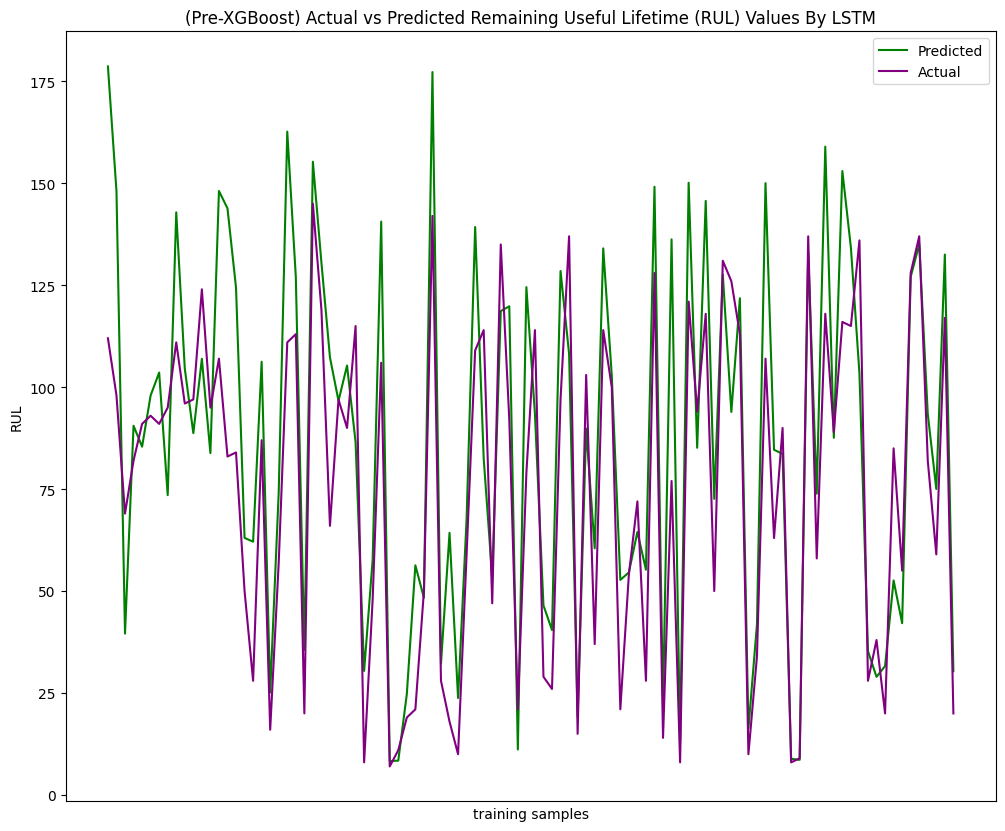

In [271]:
## use matplot

plot_result(y_true, y_pred) # plot comparisons

**Running LSTM**

In [234]:
train_dframe_lstm = pd.concat([unit_number, train_dframe], axis=1) # concatenate the frame columns

# unit_number was previously defined as the unit columns


In [235]:
## running lstm_preprocessing to check for errors

lstm_preprocessing(train_dframe_lstm, dframefd1_test, RUL.copy())

Checking difference attribute inside lstm_preprocessing...
train_dframe type: <class 'pandas.core.frame.DataFrame'>
train_dframe columns: Index(['unit', 'cycle_number', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30',
       'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32', 'RUL'],
      dtype='object')
normalize_cols: Index(['BPR', 'NRf', 'Nc', 'Nf', 'P30', 'Ps30', 'T24', 'T30', 'T50', 'W31',
       'W32', 'htBleed', 'phi'],
      dtype='object')
normalize_cols type: <class 'pandas.core.indexes.base.Index'>
train_dframe columns difference test: Index(['RUL', 'cycle_number', 'unit'], dtype='object')
Training Dataframe:      unit  cycle_number       T24       T30       T50       P30        Nf  \
0      1             1  0.183735  0.406802  0.309757  0.726248  0.242424   
1      1             2  0.283133  0.453019  0.352633  0.628019  0.212121   
2      1             3  0.343373  0.369523  0.370527  0.710145  0.272727   
3      1             4  0.343373  0.256159  0.331195  0.740741  0.318182 

(array([[[1.0000000e+00, 1.0000000e+00, 1.8373494e-01, ...,
          7.1317828e-01, 7.2466171e-01, 1.0000000e+00],
         [1.0000000e+00, 2.0000000e+00, 2.8313252e-01, ...,
          6.6666669e-01, 7.3101354e-01, 2.0000000e+00],
         [1.0000000e+00, 3.0000000e+00, 3.4337351e-01, ...,
          6.2790698e-01, 6.2137532e-01, 3.0000000e+00],
         ...,
         [1.0000000e+00, 4.8000000e+01, 2.0481928e-01, ...,
          6.2015504e-01, 6.5009665e-01, 4.8000000e+01],
         [1.0000000e+00, 4.9000000e+01, 3.0722892e-01, ...,
          7.1317828e-01, 7.6719141e-01, 4.9000000e+01],
         [1.0000000e+00, 5.0000000e+01, 4.6987951e-01, ...,
          5.5038762e-01, 7.1306270e-01, 5.0000000e+01]],
 
        [[1.0000000e+00, 2.0000000e+00, 2.8313252e-01, ...,
          6.6666669e-01, 7.3101354e-01, 2.0000000e+00],
         [1.0000000e+00, 3.0000000e+00, 3.4337351e-01, ...,
          6.2790698e-01, 6.2137532e-01, 3.0000000e+00],
         [1.0000000e+00, 4.0000000e+00, 3.4337351e-01, 

In [236]:

## attribute core variables to model training function
model, history, lstm_test_dframe, array_sequence, label_array, cycles_sequence, sequence_cols = train_models([train_dframe_lstm, dframefd1_test, RUL.copy()], "LSTM")



Checking difference attribute inside lstm_preprocessing...
train_dframe type: <class 'pandas.core.frame.DataFrame'>
train_dframe columns: Index(['unit', 'cycle_number', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30',
       'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32', 'RUL'],
      dtype='object')
normalize_cols: Index(['BPR', 'NRf', 'Nc', 'Nf', 'P30', 'Ps30', 'T24', 'T30', 'T50', 'W31',
       'W32', 'htBleed', 'phi'],
      dtype='object')
normalize_cols type: <class 'pandas.core.indexes.base.Index'>
train_dframe columns difference test: Index(['RUL', 'cycle_number', 'unit'], dtype='object')
Training Dataframe:      unit  cycle_number       T24       T30       T50       P30        Nf  \
0      1             1  0.183735  0.406802  0.309757  0.726248  0.242424   
1      1             2  0.283133  0.453019  0.352633  0.628019  0.212121   
2      1             3  0.343373  0.369523  0.370527  0.710145  0.272727   
3      1             4  0.343373  0.256159  0.331195  0.740741  0.318182 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 100)             │          46,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,051 (300.98 KB)

 Trainable params: 77,051 (300.98 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
75/75 - 30s - 400ms/step - loss: 8829.8848 - mae: 75.3087 - r2_keras: -1.7295e+00 - val_loss: 8211.4180 - val_mae: 72.1817 - val_r2_keras: -2.4526e+00
Epoch 2/60
75/75 - 33s - 437ms/step - loss: 8120.1045 - mae: 71.1364 - r2_keras: -1.5058e+00 - val_loss: 7687.6343 - val_mae: 69.1398 - val_r2_keras: -2.2053e+00
Epoch 3/60
75/75 - 22s - 296ms/step - loss: 7608.1689 - mae: 68.1973 - r2_keras: -1.3589e+00 - val_loss: 7193.9028 - val_mae: 66.2886 - val_r2_keras: -1.9741e+00
Epoch 4/60
75/75 - 20s - 266ms/step - loss: 7124.5635 - mae: 65.4394 - r2_keras: -1.1943e+00 - val_loss: 6726.0996 - val_mae: 63.6046 - val_r2_keras: -1.7569e+00
Epoch 5/60
75/75 - 25s - 338ms/step - loss: 6669.8740 - mae: 62.8535 - r2_keras: -1.0562e+00 - val_loss: 6289.7295 - val_mae: 61.1190 - val_r2_keras: -1.5564e+00
Epoch 6/60
75/75 - 37s - 492ms/step - loss: 6246.0332 - mae: 60.4665 - r2_keras: -9.2345e-01 - val_loss: 5880.5537 - val_mae: 58.8081 - val_r2_keras: -1.3707e+00
Epoch 7/60
75/75 - 20s 

**Data Visualizations for LSTM Model Predictions & Errors**

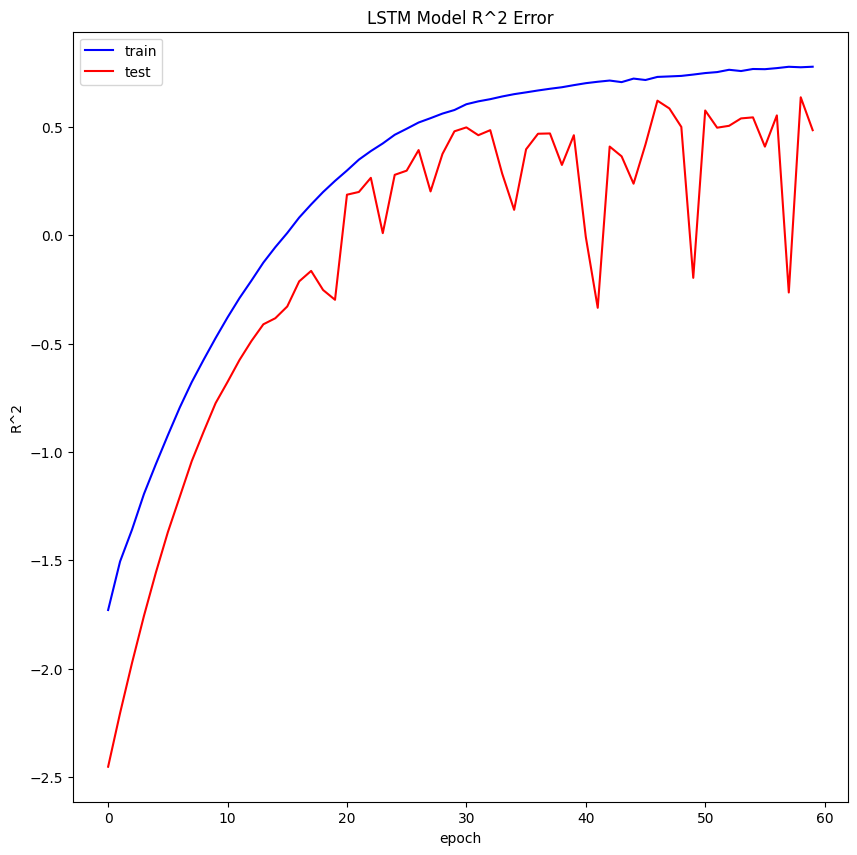

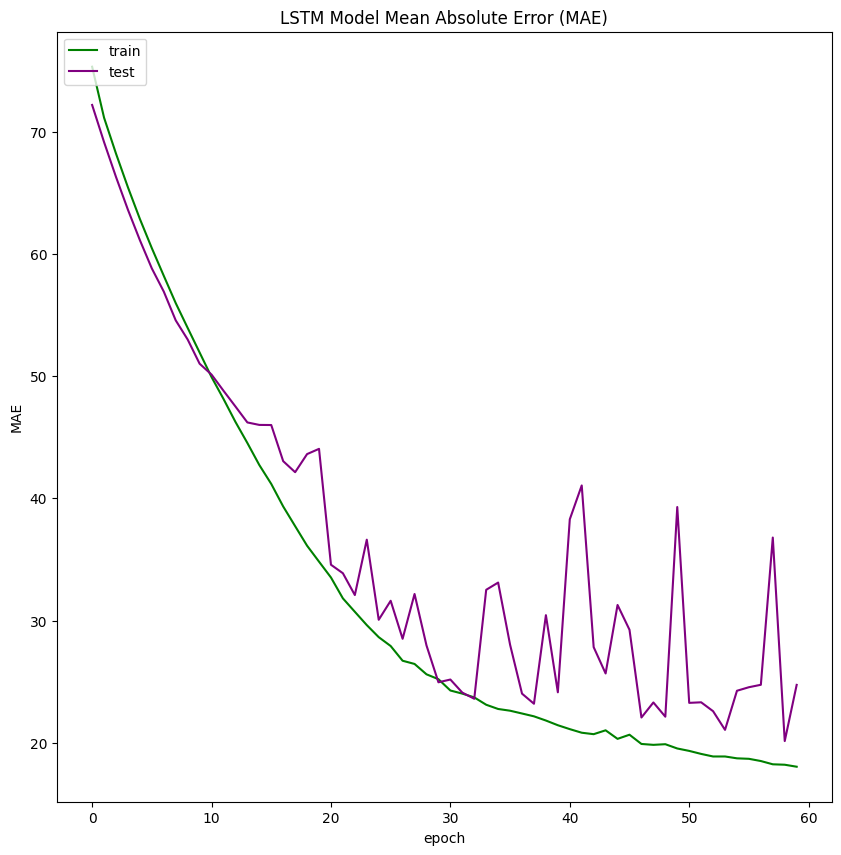

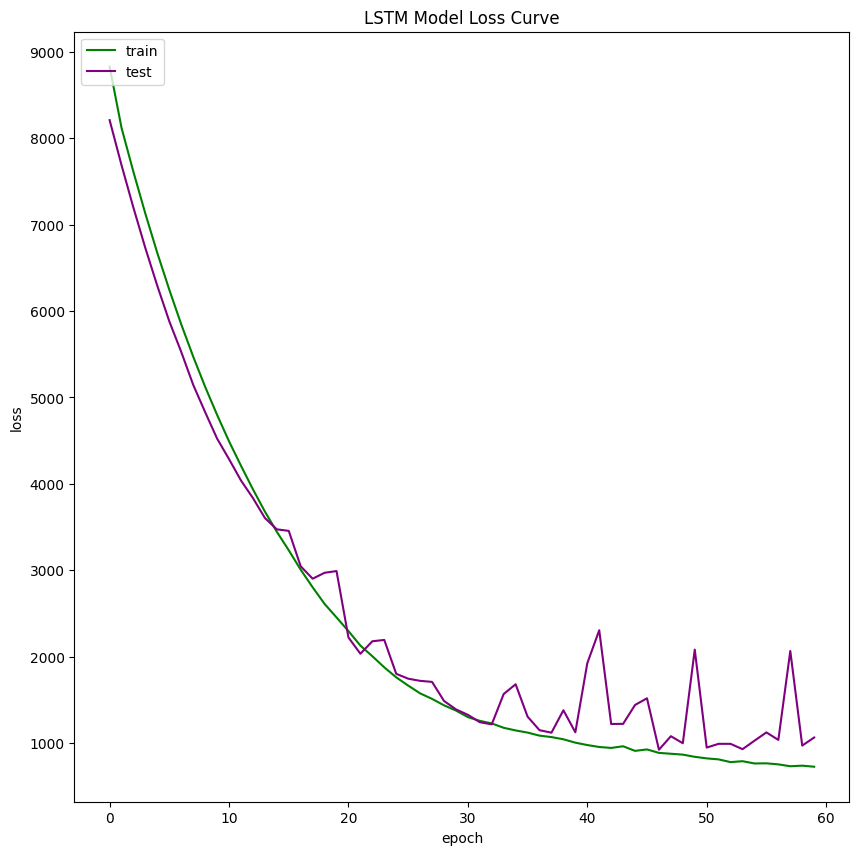

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 432.1403 - mae: 13.5730 - r2_keras: 0.8525
Score: [680.0293579101562, 16.679553985595703, 0.7745040655136108]

MAE: 16.679553985595703

R^2: 0.7745040655136108
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step


In [245]:
## dictionary now saved
## display graphs

lstm_test_eval_graph(model, history, array_sequence, label_array)

## plot the train and test r^2 error over number of epochs (60)


Generating Graphical Comparison of Predicted vs Actual RUL Data....
3/3 - 0s - 34ms/step - loss: 545.8624 - mae: 16.9068 - r2_keras: 0.6703
Score: [545.8624267578125, 16.90679931640625, 0.6703357100486755]

MAE: 16.90679931640625

R^2: 0.6703357100486755
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


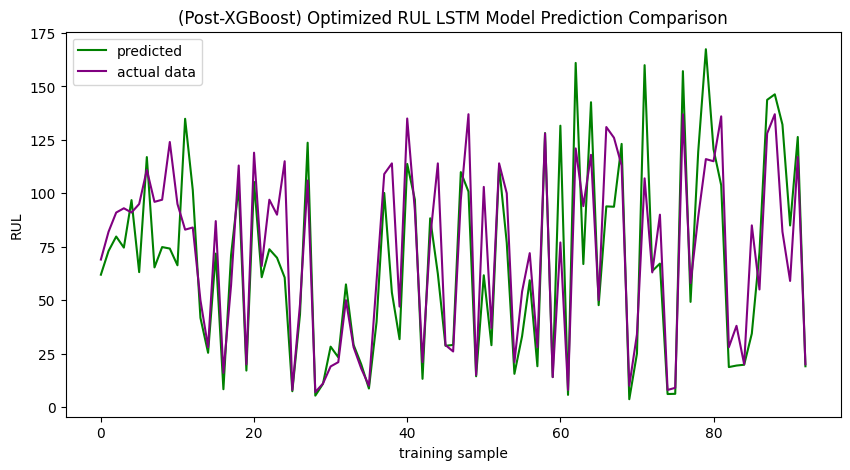

In [273]:
## IF REQUIRING GRAPHICAL DISPLAY OF PREDICTED RUL DATA:

## validation set evaluation now

# globally defining cycle_sequence (sequence length of individual engine unit analysis)
cycle_sequence = 50 # rougly 80-100 cycles in lifetime for a unit

print("Generating Graphical Comparison of Predicted vs Actual RUL Data....")

MAE, R2, y_lstm_pred = lstm_validset_eval_graphical(lstm_test_dframe, model, cycle_sequence, sequence_cols)
# create a lstm score list of errors: mae, rmse, r2
LSTM__scorelst = [round(MAE, 2), 0, round(R2, 2)*100]



In [281]:
## IF REQUIRING TABULAR DISPLAY: OF PREDICTED RUL DATA

## validation set evaluation now

# globally defining cycle_sequence (sequence length of individual engine unit analysis)
cycle_sequence = 50 # rougly 80-100 cycles in lifetime for a unit

print("Heading Input Entires For Predicted RUL.")
print()
MAEb, R2b, y_lstm_predb = lstm_validset_eval_tabular(lstm_test_dframe, model, cycle_sequence, sequence_cols)
print()
# create a lstm score list of errors: mae, rmse, r2
LSTM__scorelst = [round(MAEb, 2), 0, round(R2b, 2)*100] ## assigning "b values as it is secondary option"
print()


Heading Input Entires For Predicted RUL.

3/3 - 0s - 44ms/step - loss: 545.8624 - mae: 16.9068 - r2_keras: 0.6703
Score: [545.8624267578125, 16.90679931640625, 0.6703357100486755]

MAE: 16.90679931640625

R^2: 0.6703357100486755
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Enter the number of entries to display: 21


,Predicted RUL,Actual RUL
0,61.917969,69.000000
1,73.002144,82.000000
2,79.774986,91.000000
3,74.591370,93.000000
4,96.813927,91.000000
5,63.121399,95.000000
6,116.950005,111.000000
7,65.328476,96.000000
8,74.845703,97.000000
9,74.153297,124.000000


## **END OF LSTM MODEL VERSION 1 - Predicting Remaining Useful Lifetime (RUL) For Turbofan NASA Jet Engines**